In [190]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding, GRU, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
import tensorflow as tf
import os
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [191]:
sequences = np.load('seq_labels/sequences_pose_2nd.npy')
labels = np.load('seq_labels/labels_pose_2nd.npy')
# actions = np.array(['goodbye', 'hi', 'you', 'me', 'thankyou', 'goodmorning'])
actions = np.array(['come', 'good', 'happy', 'home', 'iloveyou', 'sorry'])
# actions = np.array(['come', 'good', 'goodbye', 'goodmorning', 'happy', 'hi', 'home', 'iloveyou', 'me', 'sorry', 'thankyou', 'you'])

In [192]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [193]:
xtrain, xrem, ytrain, yrem = train_test_split(X, y, test_size=0.3)

xval, xtest, yval, ytest = train_test_split(xrem, yrem, test_size=0.5)

# xtrain = np.load('data_2/xtrain.npy')
# ytrain = np.load('data_2/ytrain.npy')
# xval = np.load('data_2/xval.npy')
# yval = np.load('data_2/yval.npy')
# xtest = np.load('data_2/xtest.npy')
# ytest = np.load('data_2/ytest.npy')

In [77]:
np.save('data_2/xtrain.npy',xtrain)
np.save('data_2/xval.npy',xval)
np.save('data_2/xtest.npy',xtest)
np.save('data_2/ytrain.npy',ytrain)
np.save('data_2/yval.npy',yval)
np.save('data_2/ytest.npy',ytest)

In [111]:
np.random.seed(42)
tf.random.set_seed(42)
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
callback = EarlyStopping(monitor='loss', patience=3, start_from_epoch = 30)
history = History()

In [112]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
# model = Sequential()
# model.add(Conv1D(128, 3, activation='relu', input_shape=(30, 258)))
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(MaxPooling1D(3))
# model.add(Dropout(0.2))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(MaxPooling1D(3))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(512, return_sequences=True, dropout=0.2)))
# model.add(Bidirectional(LSTM(256, dropout=0.2)))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [113]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [162]:
history = model.fit(xtrain, ytrain, epochs=100, callbacks=[tb_callback, callback, history], batch_size=32, validation_data=(xval, yval))

Epoch 1/100
36/36 [==============================] - 4s 107ms/step - loss: 0.2920 - categorical_accuracy: 0.9032 - val_loss: 0.3802 - val_categorical_accuracy: 0.8740
Epoch 2/100
36/36 [==============================] - 4s 105ms/step - loss: 0.1408 - categorical_accuracy: 0.9520 - val_loss: 0.3566 - val_categorical_accuracy: 0.8862
Epoch 3/100
36/36 [==============================] - 4s 109ms/step - loss: 0.3227 - categorical_accuracy: 0.9276 - val_loss: 1.4786 - val_categorical_accuracy: 0.5407
Epoch 4/100
36/36 [==============================] - 4s 105ms/step - loss: 0.6545 - categorical_accuracy: 0.7594 - val_loss: 0.5001 - val_categorical_accuracy: 0.8252
Epoch 5/100
36/36 [==============================] - 4s 106ms/step - loss: 0.3106 - categorical_accuracy: 0.8779 - val_loss: 0.5770 - val_categorical_accuracy: 0.8130
Epoch 6/100
36/36 [==============================] - 4s 117ms/step - loss: 0.2176 - categorical_accuracy: 0.9233 - val_loss: 0.3830 - val_categorical_accuracy: 0.869

KeyboardInterrupt: 

In [134]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            82688     
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 12)                396       
                                                                 
Total params: 237,548
Trainable params: 237,548
Non-tr

In [176]:
model.load_weights('islr_all_1.h5')

In [177]:
res = model.predict(xtest)

8/8 [==============================] - 0s 48ms/step


In [178]:
actions[np.argmax(res[190])]

'sorry'

In [179]:
actions[np.argmax(yval[190])]

'good'

In [149]:
model.save('islr_all_1.h5')

In [180]:
yhat = model.predict(xtest)

8/8 [==============================] - 0s 53ms/step


In [181]:
ytrue = np.argmax(ytest, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [182]:
cm = confusion_matrix(ytrue,yhat)

In [183]:
cm_df = pd.DataFrame(cm,
                     index = actions, 
                     columns = actions)

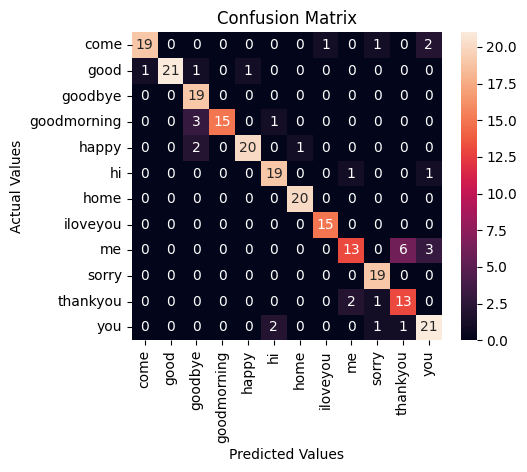

In [184]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [185]:
mcm1 = multilabel_confusion_matrix(ytrue, yhat)
print(mcm1)

[[[222   1]
  [  4  19]]

 [[222   0]
  [  3  21]]

 [[221   6]
  [  0  19]]

 [[227   0]
  [  4  15]]

 [[222   1]
  [  3  20]]

 [[222   3]
  [  2  19]]

 [[225   1]
  [  0  20]]

 [[230   1]
  [  0  15]]

 [[221   3]
  [  9  13]]

 [[224   3]
  [  0  19]]

 [[223   7]
  [  3  13]]

 [[215   6]
  [  4  21]]]


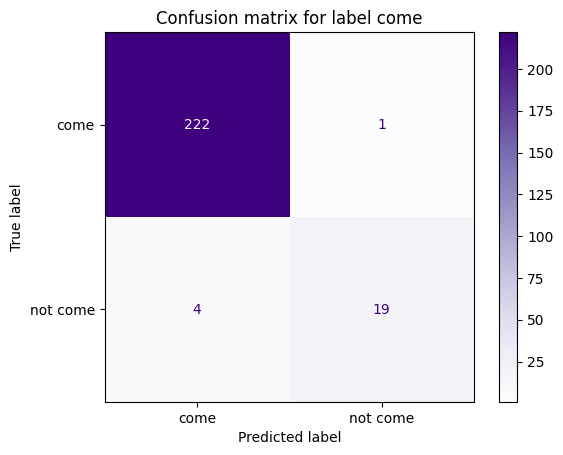

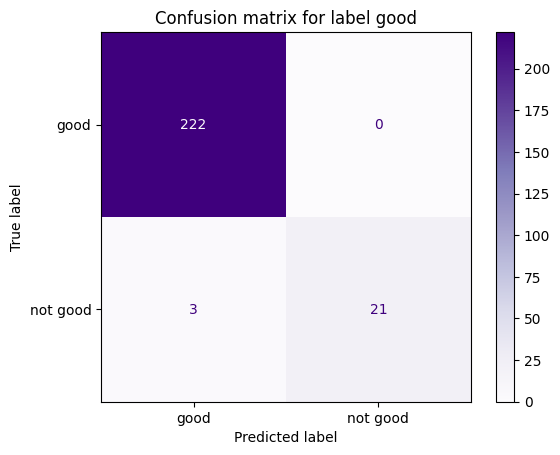

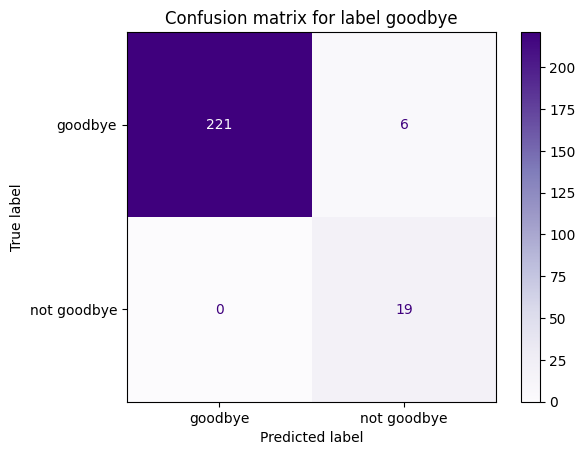

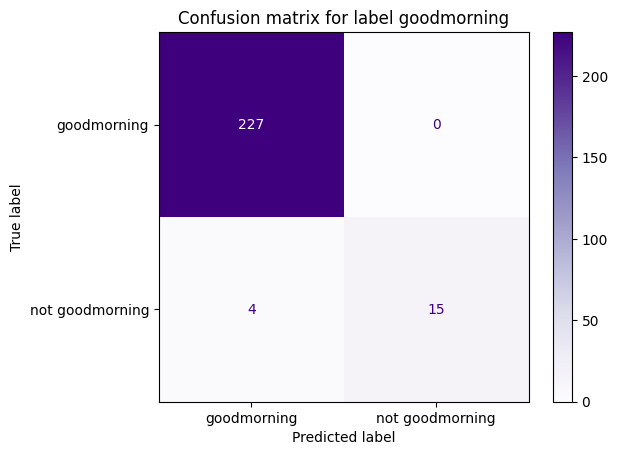

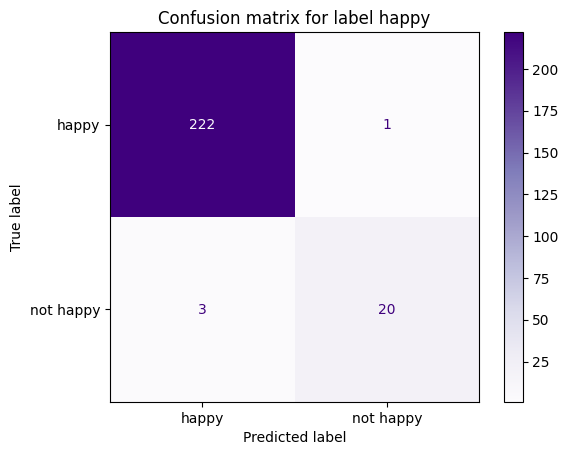

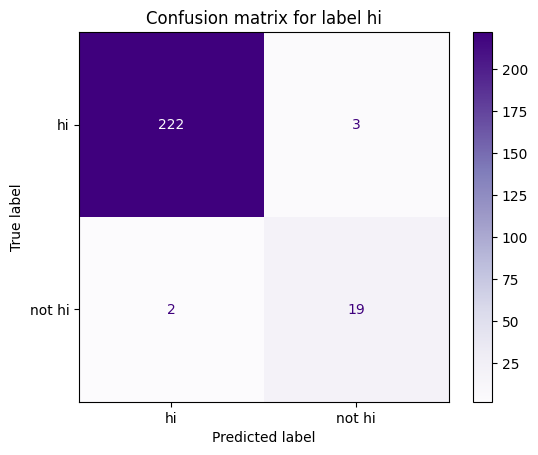

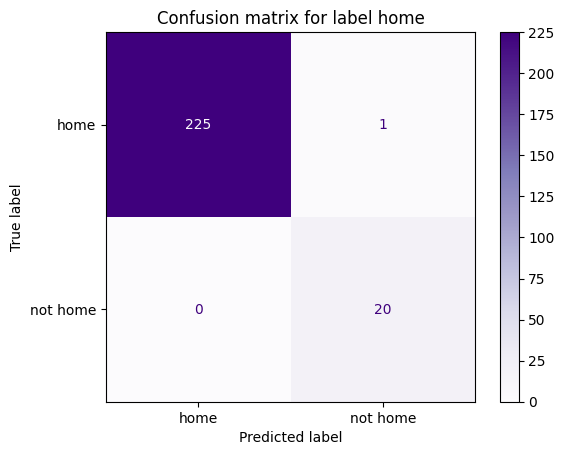

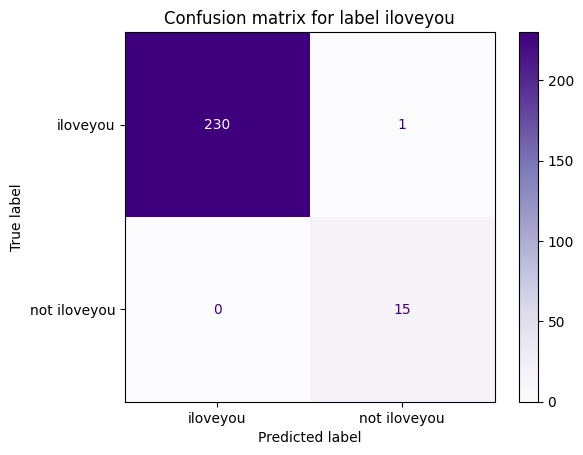

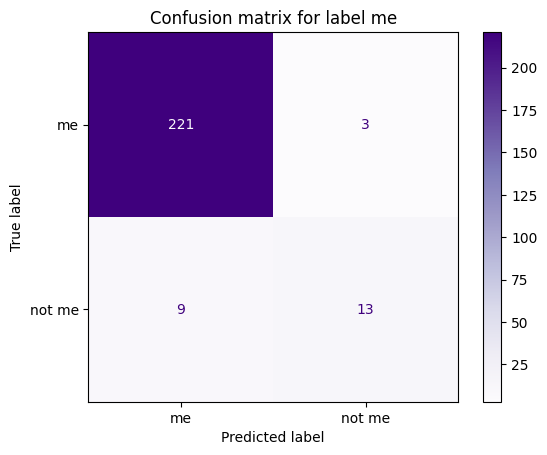

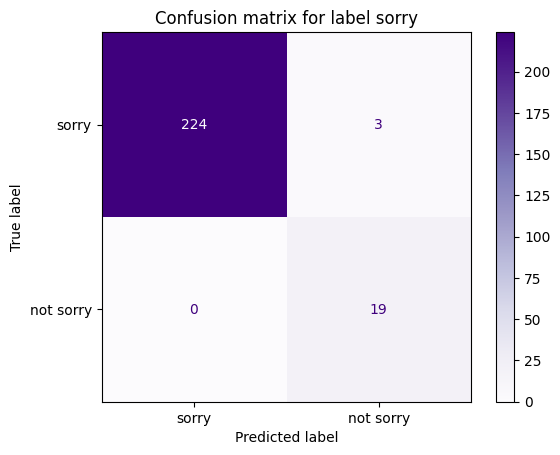

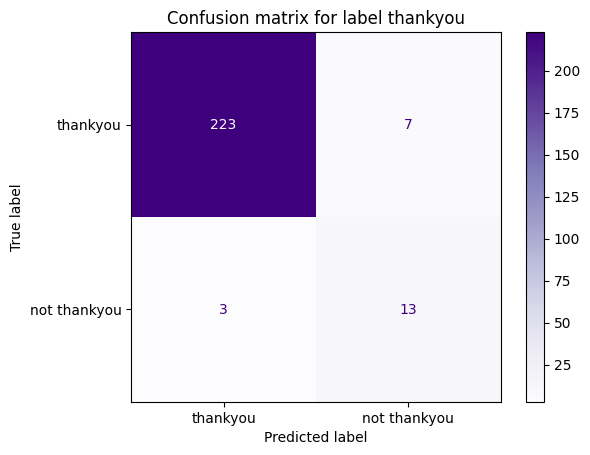

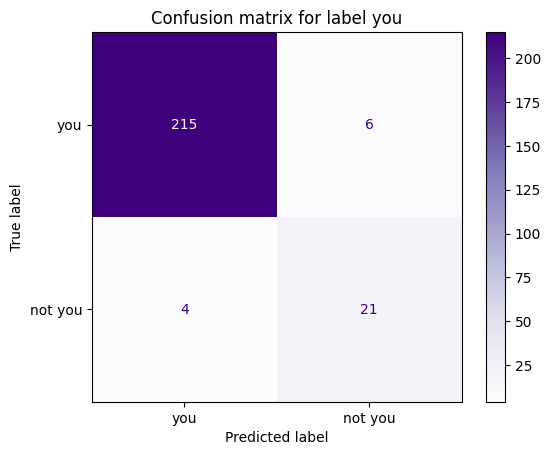

In [186]:
for i, confm in enumerate(mcm1):
    disp = ConfusionMatrixDisplay(confusion_matrix=confm, display_labels=[actions[i], 'not '+actions[i]])
    disp.plot(cmap=plt.cm.Purples)
    plt.title(f'Confusion matrix for label {actions[i]}')
    plt.show()

In [187]:
acc = accuracy_score(ytrue, yhat)
rec_w = recall_score(ytrue, yhat, average = 'weighted')
rec_n = recall_score(ytrue, yhat, average = None)
pre_w = precision_score(ytrue, yhat, average = 'weighted')
pre_n = precision_score(ytrue, yhat, average = None)
f1_w = f1_score(ytrue, yhat, average = 'weighted')
f1_n = f1_score(ytrue, yhat, average = None)


print('Accuracy: ', round(acc, 3))
print('Recall (weighted): ', round(rec_w, 3))
print('Precision (weighted): ', round(pre_w, 3))
print('F1 score (weighted): ', round(f1_w, 3))

print('Recall : ', [round(x, 3) for x in rec_n])
print('Precision : ', [round(x, 3) for x in pre_n])
print('F1 score : ', [round(x, 3) for x in f1_n])


Accuracy:  0.87
Recall (weighted):  0.87
Precision (weighted):  0.88
F1 score (weighted):  0.869
Recall :  [0.826, 0.875, 1.0, 0.789, 0.87, 0.905, 1.0, 1.0, 0.591, 1.0, 0.812, 0.84]
Precision :  [0.95, 1.0, 0.76, 1.0, 0.952, 0.864, 0.952, 0.938, 0.812, 0.864, 0.65, 0.778]
F1 score :  [0.884, 0.933, 0.864, 0.882, 0.909, 0.884, 0.976, 0.968, 0.684, 0.927, 0.722, 0.808]


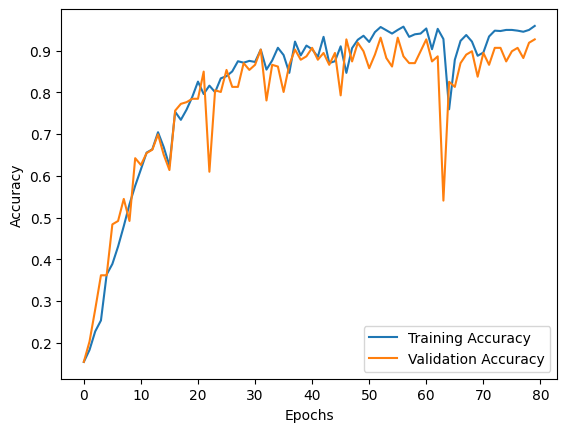

In [188]:
plt.plot(history.history['categorical_accuracy'],label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

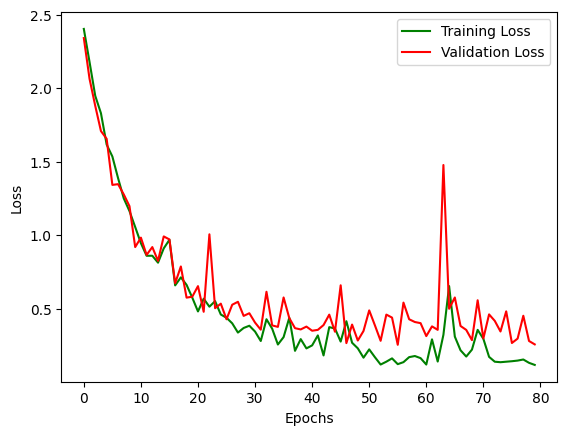

In [189]:
plt.plot(history.history['loss'], color= 'green',label='Training Loss')
plt.plot(history.history['val_loss'], color= 'red', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()